# Transfer learning with data augmentation

One of the challenges in training CNNs for computer-vision tasks is making sure that a model trained to recognize objects such as cats and dogs can recognize them in different sizes and orientations. Another challenge is coming up with lots of images to train them with. One solution to both of these problems is [data augmentation](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/), which takes existing images and generates new ones by rotating them, scaling them, translating them, and more. Keras's [ImageDataGenerator](https://keras.io/api/preprocessing/image/#imagedatagenerator-class) class supports data augmentation and includes properties with names such as `rotation_range` and `zoom_range` that you can initialize to control what transforms you want to apply and how to apply them. Let's build on the previous example that demonstrated transfer learning by enhancing it to use data augmentation.

![](Images/augmentation.png)

## Create an image pipeline

As before, we'll use Keras's [ImageDataGenerator](https://keras.io/api/preprocessing/image/#imagedatagenerator-class) class to create a pipeline for loading images. This time, however, we will configure the training-image generator to generate additional images by rotating, scaling, and flipping existing images. Note that augmentation is applied to training images but *not* to test images.

In [1]:
# Create generators to wrap images and labels
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input

batch_size = 5
multiplier = 4

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input) # No augmentation on test images

train_generator = train_datagen.flow_from_directory(
    directory='food/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False, # Avoid shuffling so labels can be recreated
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory='food/test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False, # Avoid shuffling so labels can be recreated
    seed=42
)

Using TensorFlow backend.
Found 60 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


In order to visualize the data, let's use Matplotlib to plot the first eight training images. The images look different than before because the `preprocess_input` function converts them from RGB format to BGR, but they are still recognizable as food images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


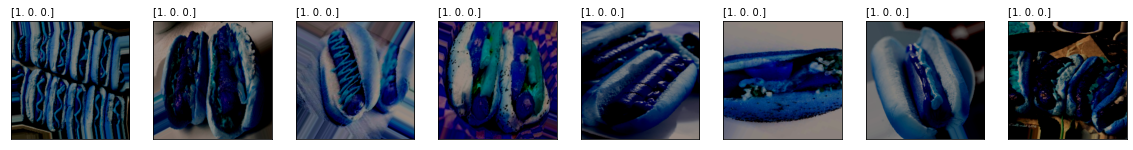

In [2]:
# Plot the first 8 training images and show the corresponding labels
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

images = np.concatenate([train_generator[0][0], train_generator[1][0]]) # First 10 images
labels = np.concatenate([train_generator[0][1], train_generator[1][1]]) # First 10 labels

fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.text(0.0, 1.05, str(labels[i]), transform=ax.transAxes)
    
train_generator.reset()

Now let's do the same for the first eight test images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


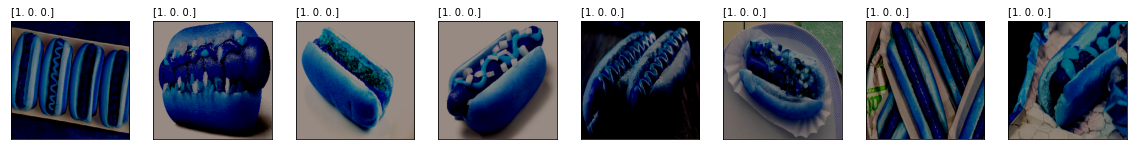

In [3]:
# Plot the first 8 test images and show the corresponding labels
images = np.concatenate([test_generator[0][0], test_generator[1][0]]) # First 10 images
labels = np.concatenate([test_generator[0][1], test_generator[1][1]]) # First 10 labels

fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.text(0.0, 1.05, str(labels[i]), transform=ax.transAxes)
    
test_generator.reset()

## Use ResNet50V2 to extract features from images

Rather than create a CNN of our own, we will load `ResNet50V2` minus the classification layers and initialize it with the weights arrived at when it was trained on the [ImageNet](http://www.image-net.org/) dataset. We will then run our training and test images through it to extract features from them. Note that we pass 240 training images through `ResNet50V2`, even though `ImageDataGenerator` was provided with just 60 training images. Thanks to data augmentation, there is a theoretically infinite number of different training images available.

In [4]:
# Load ResNet50V2 without a classification layer and run all the images through it to generate training and testing data
from keras.applications import ResNet50V2

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

train_x = base_model.predict_generator(train_generator, (train_generator.samples // batch_size) * multiplier)
test_x = base_model.predict_generator(test_generator, test_generator.samples // batch_size)

train_generator.reset()
test_generator.reset()

Now let's generate a set of labels to go with the features extracted from the training and test images.

In [5]:
# Generate labels for training and testing
train_y = []
iterations = train_generator.samples // batch_size

for i in range(multiplier):
    for i in range(iterations):
        train_y.extend(np.array(train_generator[i][1]))

train_y = np.array(train_y)

test_y = []
iterations = test_generator.samples // batch_size

for i in range(iterations):
    test_y.extend(np.array(test_generator[i][1]))
    
test_y = np.array(test_y)

train_generator.reset()
test_generator.reset()

## Train a network with the output from ResNet50V2

Now that we've used `ResNet50V2` to process augmented hot-dog, pizza, and sushi images, it's a simple matter to replace that network's classification layers with classification layers of our own and train them with the output. Once more, we'll be rather aggressive about dropout in hopes that the network will generalize better.

In [6]:
# Build a network for classification and train it with the output from ResNet50V2
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
model.add(Flatten(input_shape=train_x.shape[1:]))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

hist = model.fit(train_x, train_y, epochs=20, batch_size=batch_size, validation_data=(test_x, test_y))

Train on 240 samples, validate on 30 samples
Epoch 1/20
240/240 [==============================] - 2s 9ms/step - loss: 2.7190 - acc: 0.7750 - val_loss: 0.3049 - val_acc: 0.9333
Epoch 2/20
240/240 [==============================] - 2s 8ms/step - loss: 0.1490 - acc: 0.9458 - val_loss: 0.3229 - val_acc: 0.9000
Epoch 3/20
240/240 [==============================] - 2s 8ms/step - loss: 0.4100 - acc: 0.9125 - val_loss: 0.6278 - val_acc: 0.9333
Epoch 4/20
240/240 [==============================] - 2s 8ms/step - loss: 0.7205 - acc: 0.9208 - val_loss: 1.1039e-04 - val_acc: 1.0000
Epoch 5/20
240/240 [==============================] - 2s 8ms/step - loss: 0.1162 - acc: 0.9583 - val_loss: 0.0458 - val_acc: 0.9667
Epoch 6/20
240/240 [==============================] - 2s 8ms/step - loss: 0.1679 - acc: 0.9500 - val_loss: 0.3655 - val_acc: 0.9667
Epoch 7/20
240/240 [==============================] - 2s 8ms/step - loss: 0.1085 - acc: 0.9542 - val_loss: 0.0648 - val_acc: 0.9667
Epoch 8/20
240/240 [=======

How well did the network train? As usual, we can find out by plotting the training accuracy and validation accuracy for each epoch.

[]

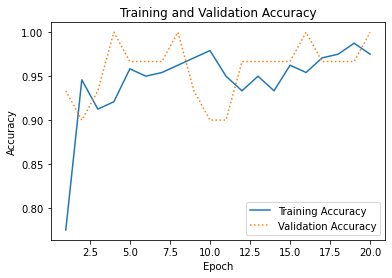

In [7]:
# Plot training accuracy and validation accuracy over time
acc = hist.history['acc']
val_acc = hist.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Is the validation accuracy higher than that of the network trained with just 60 images? How did data augmentation affect the training time? Finally, how would you modify this example to train with 480 images rather than 240, and how might that impact the accuracy?

## Make a prediction

What happens if the network is used to classify an image that it hasn't seen before? And how do you go about making such a prediction? Let's take a sushi image and see how the network classifies it. The first step is to load the image.

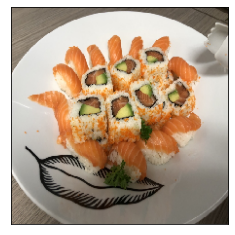

In [8]:
# Load and display the image to be classified
from keras.preprocessing import image

x = image.load_img('food/samples/sushi.jpg', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

Next, we preprocess the image and run it through `ResNet50V2`'s feature-extraction layers, and then run the output through our newly trained classification layers.

In [9]:
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)/255 # Divide by 255 to rescale the image the same way ImageDataGenerator did

# Make a prediction
y = base_model.predict(x)
predictions = model.predict(y)
print(predictions[0])

[3.1409600e-13 2.9810816e-13 1.0000000e+00]


Given that [1. 0. 0.] represents a 100% certainty that the image contains a hot dog, [0. 1. 0.] indicates that the image contains pizza, and [0. 0. 1.] indicates that it contains sushi, what did the network conclude about this photo?